JPX is hosting this competition and is supported by AI technology company AlpacaJapan Co.,Ltd.

This competition will compare your models against real future returns after the training phase is complete. The competition will involve building portfolios from the stocks eligible for predictions (around 2,000 stocks). Specifically, each participant ranks the stocks from highest to lowest expected returns and is evaluated on the difference in returns between the top and bottom 200 stocks.

In this notebook I will be doing some basic EDA and some feature creation to feed into high depth XGBoost decission trees.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm
import jpx_tokyo_market_prediction
from sklearn.model_selection import train_test_split
import warnings; warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import gc
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

Loading the training files, suppliment files and the file contais list of all the stocks.

In [2]:
stock_list = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")
prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
financials = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv")
options = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
sprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv")
supplemental_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")
supplemental_sprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/secondary_stock_prices.csv")
testprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv")
teststockprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv")

Check the basic information about the files loaded into dataframes

In [3]:
supplemental_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195993 entries, 0 to 195992
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   RowId             195993 non-null  object 
 1   Date              195993 non-null  object 
 2   SecuritiesCode    195993 non-null  int64  
 3   Open              195402 non-null  float64
 4   High              195402 non-null  float64
 5   Low               195402 non-null  float64
 6   Close             195402 non-null  float64
 7   Volume            195993 non-null  int64  
 8   AdjustmentFactor  195993 non-null  float64
 9   ExpectedDividend  1956 non-null    float64
 10  SupervisionFlag   195993 non-null  bool   
 11  Target            195989 non-null  float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 16.6+ MB


In [4]:
supplemental_prices['Date'].unique()
len(supplemental_prices['Date'].unique())

98

In [5]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [6]:
len(prices['Date'].unique())

1202

In [7]:
prices[prices['Target'] == prices['Target'].max()]

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
441408,20171214_3540,2017-12-14,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,True,1.119512


In [8]:
# stock_list[stock_list['SecuritiesCode']==6541]

In [9]:
# prices[prices['Date']=='2017-01-04']
# t = prices[prices['SecuritiesCode']==6541]
# t = t.set_index("Date")
# t
# prices.head(30)

In [10]:
### # ax = t[['Date','Target']]
# ax = t[['Volume','Target']]
# plt = ax.plot(figsize=(20, 10))

In [11]:
##### graph1

# import matplotlib.pyplot as plt

# # prices[prices['Date']=='2017-01-04']
# t1 = prices[prices['SecuritiesCode']==6541]
# # t = t.set_index("Date")
# # t

# plt.subplot(2, 1 ,1)
# plt.plot(t1.Date, t1.Close, 'b')
# plt.xlabel('SEASON')
# # plt.xticks(t.Date, rotation='vertical')
# plt.title('Close')

# plt.subplot(2, 1 ,2)
# plt.plot(t1.Date, t1.Target, 'r')
# plt.xlabel('SEASON')
# # plt.xticks(t.Date, rotation='vertical')
# plt.title('Target')

# plt.subplot(2, 1 ,3)
# plt.plot(t1.Date, t1.Volume, 'r')
# plt.xlabel('SEASON')
# # plt.xticks(t.Date, rotation='vertical')
# plt.title('Volume')

# plt.tight_layout() #隔開兩個圖
# plt.show()

In [12]:
# l = prices['SecuritiesCode'].unique()
# l[:50]

In [13]:
# m = prices['SecuritiesCode'].unique()[3:6]
# stock_list[(stock_list['SecuritiesCode']== 1381) | (stock_list['SecuritiesCode']== 1407)| (stock_list['SecuritiesCode']== 137)]
# m

In [14]:
##### graph2

# for stock_code in prices['SecuritiesCode'].unique()[6:9]:
#     plot_candle_with_target(stock_code)

In [15]:
##### graph3

# import matplotlib.pyplot as plt
# t1 = prices[prices['SecuritiesCode']==1429]

# fig, axs = plt.subplots(3, sharex=True,figsize=(10,10))
# fig.suptitle('Sharing both axes')
# axs[0].plot(t1.Date, t1.Close)
# # plt.title('Close')
# axs[1].plot(t1.Date, t1.Target,'r')
# # plt.title('Target')
# axs[2].plot(t1.Date, t1.Volume,'g')
# # plt.title('Volume')

In [16]:
### graph function

# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# def plot_candle_with_target(stock_code, prime=True):
#     """Plot OHLCV plot with target series.
    
#     Parameters:
#         stock_code: int, code of the stock
#         prime: bool, whether the stock to plot is prime or not
#     """
#     df_ = prices.copy() if prime else prices_sec.copy()
#     df_ = df_[df_['SecuritiesCode'] == stock_code]
#     dates = df_['Date'].values
#     ohlc = {
#         'open': df_['Open'].values, 
#         'high': df_['High'].values, 
#         'low': df_['Low'].values, 
#         'close': df_['Close'].values
#     }
#     vol = df_['Volume'].values
#     target = df_['Target'].values
    
#     fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
#     fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
#                   row=1, col=1)
#     fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'),
#                   row=2, col=1)
#     fig.add_trace(go.Scatter(x=dates, y=target, name='Target'),
#                   row=3, col=1)
#     fig.update_layout(
#         title=f"OHLCV Chart with Target Series (Stock {stock_code})",
#     )
#     fig.update(layout_xaxis_rangeslider_visible=False)
#     fig.show()

In [17]:
# stock_list.info()

In [18]:
# stock_list.head(2)

Append the secondary prices and suppliment prices

In [19]:
prices=prices.append(sprices,ignore_index=True)
prices=prices.append(supplemental_prices,ignore_index=True)
prices=prices.append(supplemental_sprices,ignore_index=True)
prices=prices.drop(['RowId','ExpectedDividend'],axis=1)
prices=prices.dropna()

In [20]:
# sprices.tail(50)
# supplemental_sprices.tail(50)
# stock_list[stock_list['SecuritiesCode']== 9776]

In [21]:
# prices.tail(5)

In [22]:
# plt.scatter(prices['Date'],prices['Target'])

Separate train and test data sets

In [23]:
prices['DateValue']=prices['Date'].str.replace('-','')
xprices=prices[prices['DateValue']<'20220401']
xprices=xprices.drop(['DateValue'],axis=1)
yprices=prices[prices['DateValue']>='20220401']
yprices=yprices.drop(['DateValue'],axis=1)

In [24]:
# yprices.count()
xprices.shape

(4932293, 10)

In [25]:
gc.collect()

156

pop the target values into another dataframe

In [26]:
y_train=xprices.pop('Target')
y_test=yprices.pop('Target')
X_train=xprices
X_test=yprices

In [27]:
# X_train.head(30)

In [28]:
# tst = X_train[:20000].copy()
# for code in tst['SecuritiesCode'].unique():
    
#     tst2=tst[tst['SecuritiesCode']==code].copy()
#     tst2['MA5'] = tst2.Close.rolling(5, min_periods=1).mean()
#     tst2['MA10'] = tst2.Close.rolling(10, min_periods=1).mean()
#     print(tst2)


# len(tst['SecuritiesCode'].unique())
# tst[tst['SecuritiesCode'] == 1301]
# tst

In [29]:
del prices
del xprices
del yprices

feature engineering

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def featuring(train):
    train1 = train.copy()
    dfa=pd.DataFrame()
    for code in train1['SecuritiesCode'].unique():
        df=train1[train1['SecuritiesCode']==code].copy()
        
        df=df.sort_values(by=['Date'], ascending=True)
#         print(df)
#         print("--")
        
        df['RA_5'] = df.Close.rolling(5, min_periods=1).mean()
        df['RA_10'] = df.Close.rolling(10, min_periods=1).mean()
        df['RA_20'] = df.Close.rolling(20, min_periods=1).mean()
#         df['RA_60'] = df.Close.rolling(60, min_periods=1).mean()
        
#         df['RA_5_per'] = (df['Close']-df['RA_5'])/df['RA_5']
#         df['RA_10_per'] = (df['Close']-df['RA_10'])/df['RA_10']
#         df['RA_20_per'] = (df['Close']-df['RA_20'])/df['RA_20']
#         df['RA_60_per'] = (df['Close']-df['RA_60'])/df['RA_60']
        
        conditions1 = [
            ((df['RA_5'] > df['RA_10']) & (df['RA_10'] > df['RA_20'])),
            ((df['RA_5'] <= df['RA_10']) | (df['RA_10'] <= df['RA_20']))
        ]

        conditions2 = [
            ((df['RA_5'] < df['RA_10']) & (df['RA_10'] < df['RA_20'])),
            ((df['RA_5'] >= df['RA_10']) | (df['RA_10'] >= df['RA_20']))
        ]
        
        # create a list of the values we want to assign for each condition
        values1 = [1, 0]
        values2 = [1, 0]

        # create a new column and use np.select to assign values to it using our lists as arguments
        df['5_10_20_long'] = np.select(conditions1, values1)
        df['5_10_20_short'] = np.select(conditions2, values2)
        
#         print(df)
#         df['RA_60'] = df.Close.rolling(15, min_periods=1).mean()
        #df['RA_80'] = df.Close.rolling(20, min_periods=1).mean()
        #df['RA_100'] = df.Close.rolling(30, min_periods=1).mean()
        dfa=dfa.append(df)
        
#     print(dfa)
    
    dfa['year']=pd.to_numeric(dfa['Date'].str[0:4]).astype(float)
    dfa['month']=pd.to_numeric(dfa['Date'].str[5:7]).astype(float)
    dfa['day']=pd.to_numeric(dfa['Date'].str[8:10]).astype(float)
    dfa['delta']=pd.to_numeric(dfa['High']-dfa['Low']).astype(float)
    dfa['change']=pd.to_numeric(dfa['Close']-dfa['Open']).astype(float)
    
    dfa['avg_price'] = (dfa['Open']+dfa['High']+dfa['Low']+dfa['Close'])/4
    dfa['vol_amount'] = dfa['Volume']*dfa['avg_price']
    dfa['BOP'] = (dfa['Open']-dfa['Close'])/(dfa['High']-dfa['Low'])
    dfa['wp'] = (dfa['Open']+dfa['High']+dfa['Low'])/3
    dfa['TR'] = dfa['High'] - dfa['Low']
    dfa['OC'] = dfa['Open'] * dfa['Close']
    dfa['HL'] = dfa['High'] * dfa['Low']
    dfa['logC'] = np.log(dfa['Close']+1)
    dfa['OHLCstd'] = dfa[['Open','Close','High','Low']].std(axis=1)
    dfa['OHLCskew'] = dfa[['Open','Close','High','Low']].skew(axis=1)
    dfa['OHLCkur'] = dfa[['Open','Close','High','Low']].kurtosis(axis=1)
    
    dfa['Cpos'] = (dfa['Close']-dfa['Low'])/(dfa['High']-dfa['Low']) -0.5
    dfa['bsforce'] = dfa['Cpos'] * dfa['Volume']
    dfa['Opos'] = (dfa['Open']-dfa['Low'])/(dfa['High']-dfa['Low']) -0.5
    

    
    
#     dfa['Tstd'] = dfa['Target'].std(axis=1)
#     dfa['Tskew'] =dfa['Target'].skew(axis=1)
#     dfa['Tkur'] = dfa['Target'].kurtosis(axis=1)
    
    
    dfa=dfa[['Date','SecuritiesCode','delta','change','RA_5','RA_10','RA_20','year','month','day','avg_price','vol_amount','BOP','wp',
             'TR', 'OC', 'HL', 'logC',
       'OHLCstd', 'OHLCskew', 'OHLCkur', 'Cpos', 'bsforce', 'Opos'
#              ,'RA_5_per','RA_10_per','RA_20_per','RA_60_per']]
              ,'5_10_20_long','5_10_20_short']]
#     dfa=dfa[['Date','SecuritiesCode','delta','change','RA_5','RA_10','RA_20','RA_60','year','month','day','RA_5_per','RA_10_per','RA_20_per','RA_60_per']]

#     'Tstd','Tskew','Tkur'

#     dfa=dfa.join(stock_list[['17SectorCode','17SectorName']],how='left',on='SecuritiesCode',rsuffix='b')

    dfa=dfa.join(stock_list['17SectorCode'],how='left',on='SecuritiesCode',rsuffix='b')
    dfa['17SectorCode'] = dfa['17SectorCode'].replace("-","0")
    dfa['17SectorCode'] = pd.to_numeric(dfa['17SectorCode'])
    dfa['17SectorCode'] = dfa['17SectorCode'].fillna(0)

#     dfa=dfa.drop(['SecuritiesCodeb','Name', 'NewMarketSegment','33SectorCode','33SectorName','17SectorCode','17SectorName','NewIndexSeriesSizeCode', 'NewIndexSeriesSize','TradeDate','Closeb','Universe0'],axis=1)
    
    train1=train1.merge(dfa,how='left',on=['Date','SecuritiesCode'],suffixes=('', 'b')).set_axis(train.index)
    train1=train1.drop(['Date'],axis=1)

    
    
    
    
    
    
    
    
#     l = train1.columns.tolist()
    
#     ### integer mapping using LabelEncoder
#     label_encoder = LabelEncoder()
#     integer_encoded = label_encoder.fit_transform(train1['17SectorCode'])
# #     print(integer_encoded)
#     integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

#     ### One hot encoding
#     onehot_encoder = OneHotEncoder(sparse=False)
#     onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# #     encoder_df = pd.DataFrame(encoder.fit_transform(df[['team']]).toarray())
#     encoder_df = pd.DataFrame(onehot_encoded)
#     train1 = train1.join(encoder_df)
    
   
    
#     c = stock_list['17SectorCode'].unique()
#     c.sort()
# #     train.columns = l.extend(c)
#     l.extend(c)
#     print(l)
#     train1.columns = l
    
#     train1.drop(['33SectorCode', '33SectorName'],axis = 1)
    
    
    
    
#     print(onehot_encoded)
#     pd.DataFrame(data_str_ohe)
    #train=train.merge(stock_list, how='inner',on='SecuritiesCode',suffixes=('', 'b')).set_axis(train.index)
    #train=train.drop(['EffectiveDate','Name','33SectorName','17SectorName','NewIndexSeriesSize','TradeDate','Closeb'],axis=1)
    
    #dfa=dfa.drop(['SecuritiesCodeb','Name', 'NewMarketSegment','33SectorCode','33SectorName','17SectorCode','17SectorName','NewIndexSeriesSizeCode', 'NewIndexSeriesSize',
    #   'TradeDate','Closeb','Universe0'],axis=1)
    #dfa['Section']=label_encoder.fit_transform(dfa['Section/Products'])
    #dfa=dfa.drop(['Section/Products'],axis=1)
    #dfa.sort_index(inplace=True)
    return train1

In [31]:
# s = featuring(X_train[:2000])

# # s[s['33SectorCode']=="-"]
# s.tail(30)
# # s['33SectorCode'].unique()

In [32]:
# s[['17SectorCode', '17SectorName', '-', '1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']]

# s.dtypes
# s.shape

In [33]:
# s[['RA_5','RA_10','RA_20','RA_60','RA_5_per','RA_10_per','RA_20_per','RA_60_per','5_10_20_long','5_10_20_short']].tail(50)
# s.tail(50)
# s2 = s[['RA_5','RA_10','RA_20','RA_60','RA_5_per','RA_10_per','RA_20_per','RA_60_per','5_10_20_long','5_10_20_short']]
# s2[s2['5_10_20_long']==1]
# s2[s2['5_10_20_short']==1]
# s2

In [34]:
# s.columns.tolist()
# stock_list['17SectorCode'][1]

In [35]:
# d = s['33SectorCode'].unique()
# d.sort()
# d

# c = stock_list['33SectorCode'].unique()
# c.sort()
# c
               
# stock_list[['17SectorCode','17SectorName']]

In [36]:
# stock_list[stock_list['17SectorCode']=="16"]
# stock_list[stock_list['SecuritiesCode']==2109]

In [37]:
X_train=featuring(X_train)
X_test=featuring(X_test)
gc.collect()

19

In [38]:
# X_train.tail(30)
# X_test[200:1000]
# X_train.drop('17SectorCode')
# X_train.drop('17SectorName')


# X_train1 = X_train.drop(['17SectorCode','17SectorName'],axis=1)
# X_test1 = X_test.drop(['17SectorCode','17SectorName'],axis=1)

XGBoost regressor

In [39]:
# X_train1.dtypes

In [40]:
model = xgb.XGBRegressor(
    n_estimators=800,
    max_depth=16,
    learning_rate=0.01,
    subsample=0.5,
    colsample_bytree=0.75,
    missing=-999,
    random_state=2020,
    tree_method='gpu_hist', # THE MAGICAL PARAMETER
    enable_categorical=True
    )
model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)], verbose=1)
gc.collect()

[0]	validation_0-rmse:0.49705
[1]	validation_0-rmse:0.49212
[2]	validation_0-rmse:0.48723
[3]	validation_0-rmse:0.48239
[4]	validation_0-rmse:0.47760
[5]	validation_0-rmse:0.47285
[6]	validation_0-rmse:0.46816
[7]	validation_0-rmse:0.46351
[8]	validation_0-rmse:0.45891
[9]	validation_0-rmse:0.45436
[10]	validation_0-rmse:0.44986
[11]	validation_0-rmse:0.44540
[12]	validation_0-rmse:0.44098
[13]	validation_0-rmse:0.43661
[14]	validation_0-rmse:0.43229
[15]	validation_0-rmse:0.42801
[16]	validation_0-rmse:0.42377
[17]	validation_0-rmse:0.41957
[18]	validation_0-rmse:0.41541
[19]	validation_0-rmse:0.41129
[20]	validation_0-rmse:0.40721
[21]	validation_0-rmse:0.40317
[22]	validation_0-rmse:0.39917
[23]	validation_0-rmse:0.39522
[24]	validation_0-rmse:0.39131
[25]	validation_0-rmse:0.38744
[26]	validation_0-rmse:0.38361
[27]	validation_0-rmse:0.37981
[28]	validation_0-rmse:0.37605
[29]	validation_0-rmse:0.37234
[30]	validation_0-rmse:0.36866
[31]	validation_0-rmse:0.36501
[32]	validation_0-

57

predict the target value for test data

In [41]:
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [42]:
for (df_test, options, financials, trades, secondary_prices, df_pred) in iter_test:
    df_test=df_test.drop(['RowId','ExpectedDividend'],axis=1)
    print(df_test.info())
    print(df_test.head(10))
    x_test = featuring(df_test)

    y_pred = model.predict(x_test)
    df_pred['Target'] = y_pred
    df_pred = df_pred.sort_values(by = "Target", ascending = False)
    df_pred['Rank'] = np.arange(len(df_pred.index))
    df_pred = df_pred.sort_values(by = "SecuritiesCode", ascending = True)
    df_pred.drop(["Target"], axis = 1)
    submission = df_pred[["Date", "SecuritiesCode", "Rank"]]    
    env.predict(submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              2000 non-null   object 
 1   SecuritiesCode    2000 non-null   int64  
 2   Open              1994 non-null   float64
 3   High              1994 non-null   float64
 4   Low               1994 non-null   float64
 5   Close             1994 non-null   float64
 6   Volume            2000 non-null   int64  
 7   AdjustmentFactor  2000 non-null   float64
 8   SupervisionFlag   2000 non-null   bool   
dtypes: bool(1), float64(5), int64(2), object(1)
memory usage: 127.1+ KB
None
         Date  SecuritiesCode    Open    High     Low   Close   Volume  \
0  2021-12-06            1301  2982.0  2982.0  2965.0  2971.0     8900   
1  2021-12-06            1

<Figure size 12000x12000 with 0 Axes>

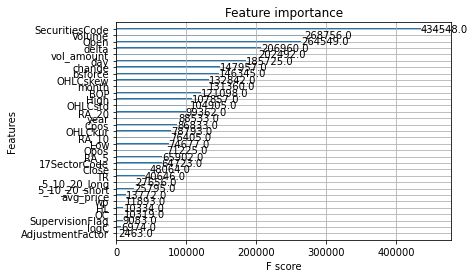

In [43]:
from xgboost import plot_importance
from matplotlib import pyplot
from matplotlib.pyplot import figure

figure(figsize=(80, 80), dpi=150)
plot_importance(model)
pyplot.show()